**Importing Required Libraries**

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
import warnings
warnings.filterwarnings('ignore')

** **bold text** Reading files**

In [15]:
train_df = pd.read_csv("reviews_train.csv")
test_df = pd.read_csv("reviews_test.csv")
train_df.head()

,review,sentiment
0,Increment is not good you have to switch in or...,0
1,It depends on the team you are working with. I...,1
2,"Might not be good at hike system, compare to o...",0
3,Less Hike and Les salary,0
4,Onsite opportunity will be minimal,0


Check Null Values

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1911 entries, 0 to 1910
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     1911 non-null   object
 1   sentiment  1911 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 30.0+ KB


#No Null rows are present.

#Distribution of data points in train df among output classes

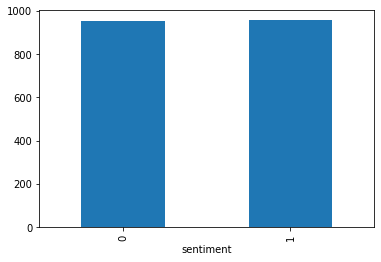

In [6]:
train_df.groupby("sentiment")['review'].count().plot.bar()

This is a  balanced dataset as label classes are equally distributed

In [7]:
print('~>  Sentiment (label = 0):\n   {}%'.format(100 - round(train_df['sentiment'].mean()*100, 2)))
print('\n~> Sentiment (label = 1):\n   {}%'.format(round(train_df['sentiment'].mean()*100, 2)))

~>  Sentiment (label = 0):
   49.97%

~> Sentiment (label = 1):
   50.03%


In [8]:
#Function for preprocessing the text data.
def load_dict_contradictions():
   return {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "I'll":"I will",
        "I'm":"I am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "Whatcha":"What are you",
        "luv":"love",
        "sux":"sucks"
 }

 #Stripping accents in dataset
def strip_accents(text):
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

# Spell Corrector

def spell_corrector(word):
  from textblob import Word
  word = Word(word)    
  result = word.correct()    
  return result

!pip install googletrans==3.1.0a0
from googletrans import Translator

def lang_translator(text):  
  translator = Translator()
  translated_text = translator.translate(text, dest='en')
  return translated_text.text
  
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 1.4 MB 10.2 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 65 kB 3.3 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=cf0bbe5bd750109f635fa939209fd97380ff628631e7f0ea6d8346b0078208ae
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans


In [9]:
# Taking care of stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
#Function for preprocessing the text data.
def preprocess_reviews(review):
    review = re.sub("[^A-Za-z]+"," ", review.lower())
    review = re.sub("\S*\d\S*", "" , review) 
    return review

In [17]:
#Applying preprocess funtions on train data
train_df['review_clean'] = train_df['review'].apply(lambda x : lang_translator(x)) #Translating to English
train_df['review_clean'] = train_df['review_clean'].apply(strip_accents) #Removing accents
train_df['review_clean'] = train_df['review_clean'].apply(lambda x: x.lower()) #Normalising review
contract = load_dict_contradictions()
train_df['review_clean'] = train_df['review_clean'].apply(lambda x: " ".join(contract[word] if word in contract.keys() else word for word in x.split()))

In [18]:
#Applying preprocess funtions on test data

test_df['review_clean'] = test_df['review'].apply(lambda x : lang_translator(x)) #Translating to English
test_df['review_clean'] = test_df['review_clean'].apply(strip_accents) #Removing accents
test_df['review_clean'] = test_df['review_clean'].apply(lambda x: x.lower()) #Normalising review
contract = load_dict_contradictions()
test_df['review_clean'] = test_df['review_clean'].apply(lambda x: " ".join(contract[word] if word in contract.keys() else word for word in x.split()))

In [14]:
#Defining Stop Word

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can','see','also','get','will', 'could','would','one','really','just', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've','...', '-....', 'xyz'])

In [19]:
#Defining Function for stop Words

def remove_stop_words(review):
    rstop_words = ""
    for word in review.split():
        if not word in stopwords:
            stop = word
            rstop_words += word
            rstop_words += " "      
    return rstop_words


In [20]:
#Removing stop word from train data
train_df['review_clean'] = train_df['review_clean'].apply(remove_stop_words)
train_df.head()

,review,sentiment,review_clean
0,Increment is not good you have to switch in or...,0,increment not good switch order good hike sala...
1,It depends on the team you are working with. I...,1,depends team working with. working good team.
2,"Might not be good at hike system, compare to o...",0,"might not good hike system, compare world lead..."
3,Less Hike and Les salary,0,less hike les salary
4,Onsite opportunity will be minimal,0,onsite opportunity minimal


In [21]:
#Removing stop words from test data
test_df['review_clean'] = test_df['review_clean'].apply(remove_stop_words)
test_df.head()

,ID,review,review_clean
0,1,when you do lots of acquisitions you screw you...,lots acquisitions screw culture
1,2,You are expected to work in client s place and...,expected work client place big data projects l...
2,3,"You get to meet a lot of people, they have man...","meet lot people, many projects, offices nice"
3,4,Learning Growth Limitation\r\r\nno one to list...,learning growth limitation no listen understan...
4,5,Work culture is good and supportive,work culture good supportive


In [22]:
#Correcting spell_checker on train data
train_df['review_clean'] = train_df['review_clean'].apply(lambda x : " ".join(spell_corrector(word) for word in x.split()))
train_df['review_clean']

0       incitement not good switch order good like salary
1             depends team working with working good team
2       might not good like system compare world leade...
3                                    less like les salary
4                              inside opportunity minimal
5                            less none inside opportunity
6                            no increments , variable pay
7                             depends project no learning
8                                great company learn grow
9             political company of depressing environment
10              good working culture supporting colleague
11                                            no corns of
12      less pure development opportunity... support o...
13                           much inside right candidates
14      good culture good environment new technology g...
15      good work culture better life balance good lea...
16      compensation/benefits/increments not satisfactory
17            

In [23]:
#correcting spelling on test data
test_df['review_clean'] = test_df['review_clean'].apply(lambda x : " ".join(spell_corrector(word) for word in x.split()))
# test_df['review_clean']

In [24]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
#Lemmatization Function

def get_lemmatized_text(review):
    lemmatizer = WordNetLemmatizer()
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lem = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(review)]
    res = " ".join(lem)
    return res


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [25]:

train_df['review_clean'] = train_df['review_clean'].apply(get_lemmatized_text)
train_df.head()

,review,sentiment,review_clean
0,Increment is not good you have to switch in or...,0,incitement not good switch order good like salary
1,It depends on the team you are working with. I...,1,depends team working with working good team
2,"Might not be good at hike system, compare to o...",0,might not good like system compare world leade...
3,Less Hike and Les salary,0,le like le salary
4,Onsite opportunity will be minimal,0,inside opportunity minimal


In [26]:

test_df['review_clean'] = test_df['review_clean'].apply(get_lemmatized_text)
test_df.head()

,ID,review,review_clean
0,1,when you do lots of acquisitions you screw you...,lot acquisition screw culture
1,2,You are expected to work in client s place and...,expected work client place big data project le...
2,3,"You get to meet a lot of people, they have man...",meet lot people many project office nice
3,4,Learning Growth Limitation\r\r\nno one to list...,learning growth limitation no listen understan...
4,5,Work culture is good and supportive,work culture good suppurative


In [29]:
#Function for preprocessing the text data.
import re

def preprocess_reviews(review):
    review = re.sub("[^A-Za-z]+"," ", review.lower())
    review = re.sub("\S*\d\S*", "" , review) 
    return review

In [30]:
# train_df['review_clean'] = train_df['review_clean'].apply(preprocess_reviews)
# test_df['review_clean'] = test_df['review_clean'].apply(preprocess_reviews)

pd.to_csv('cleaned_train_data.csv')
pd.to_csv('cleaned_test_data.csv')

In [31]:
#Joining all the reviews of train_df for visuals.
reviews_combinedlemm = " ".join(train_df.review_clean.values)

word_cloud = WordCloud(width=800,height=400,background_color='white',max_words=100, random_state = 59,stopwords = stopwords).\
generate_from_text(reviews_combinedlemm)

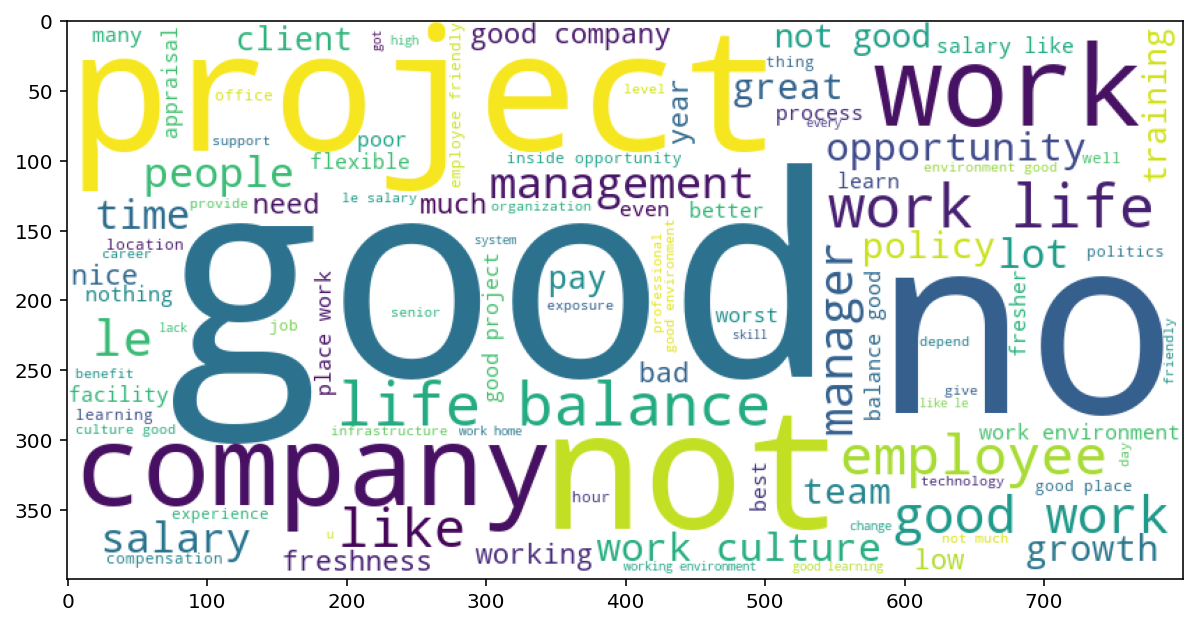

In [32]:
%config InlineBackend.figure_format='retina'
plt.figure(figsize=[10,10])
plt.imshow(word_cloud)
plt.show()

In [33]:
#Joining all the reviews of test_df for visuals.
reviews_combinedlemm = " ".join(test_df.review_clean.values)

In [34]:
word_cloud = WordCloud(width=800,height=400,background_color='white',max_words=50, random_state = 59,stopwords = stopwords).\
generate_from_text(reviews_combinedlemm)

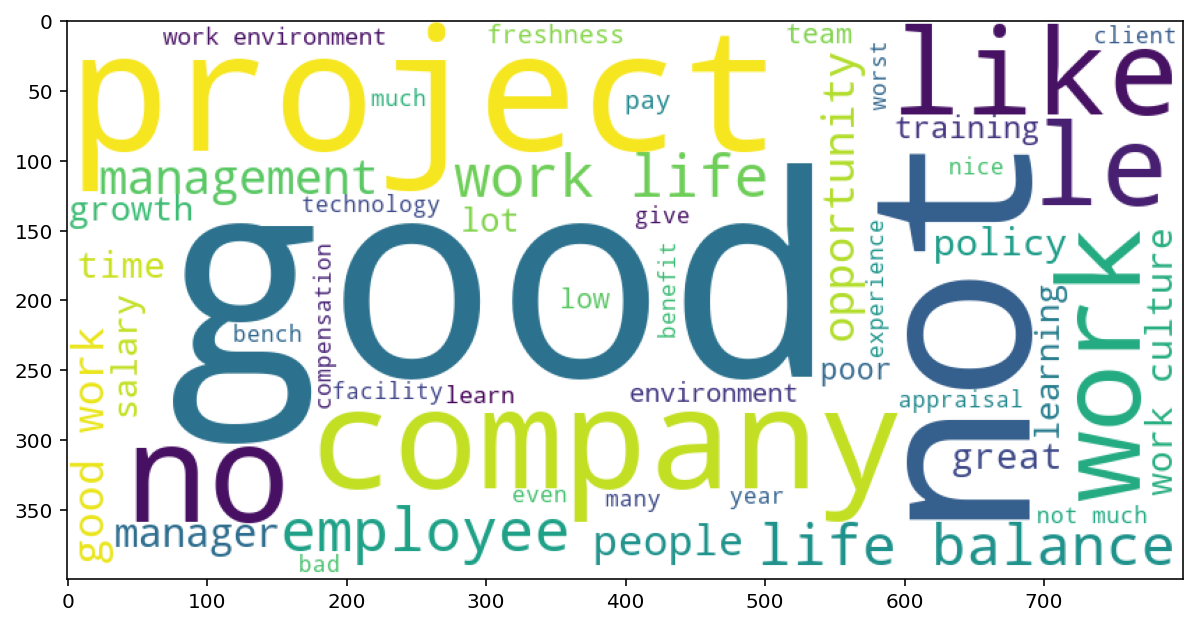

In [35]:
%config InlineBackend.figure_format='retina'
plt.figure(figsize=[10,10])
plt.imshow(word_cloud)
plt.show()

#the bar graph for top 25 frequenctly used unigrams for train and test 

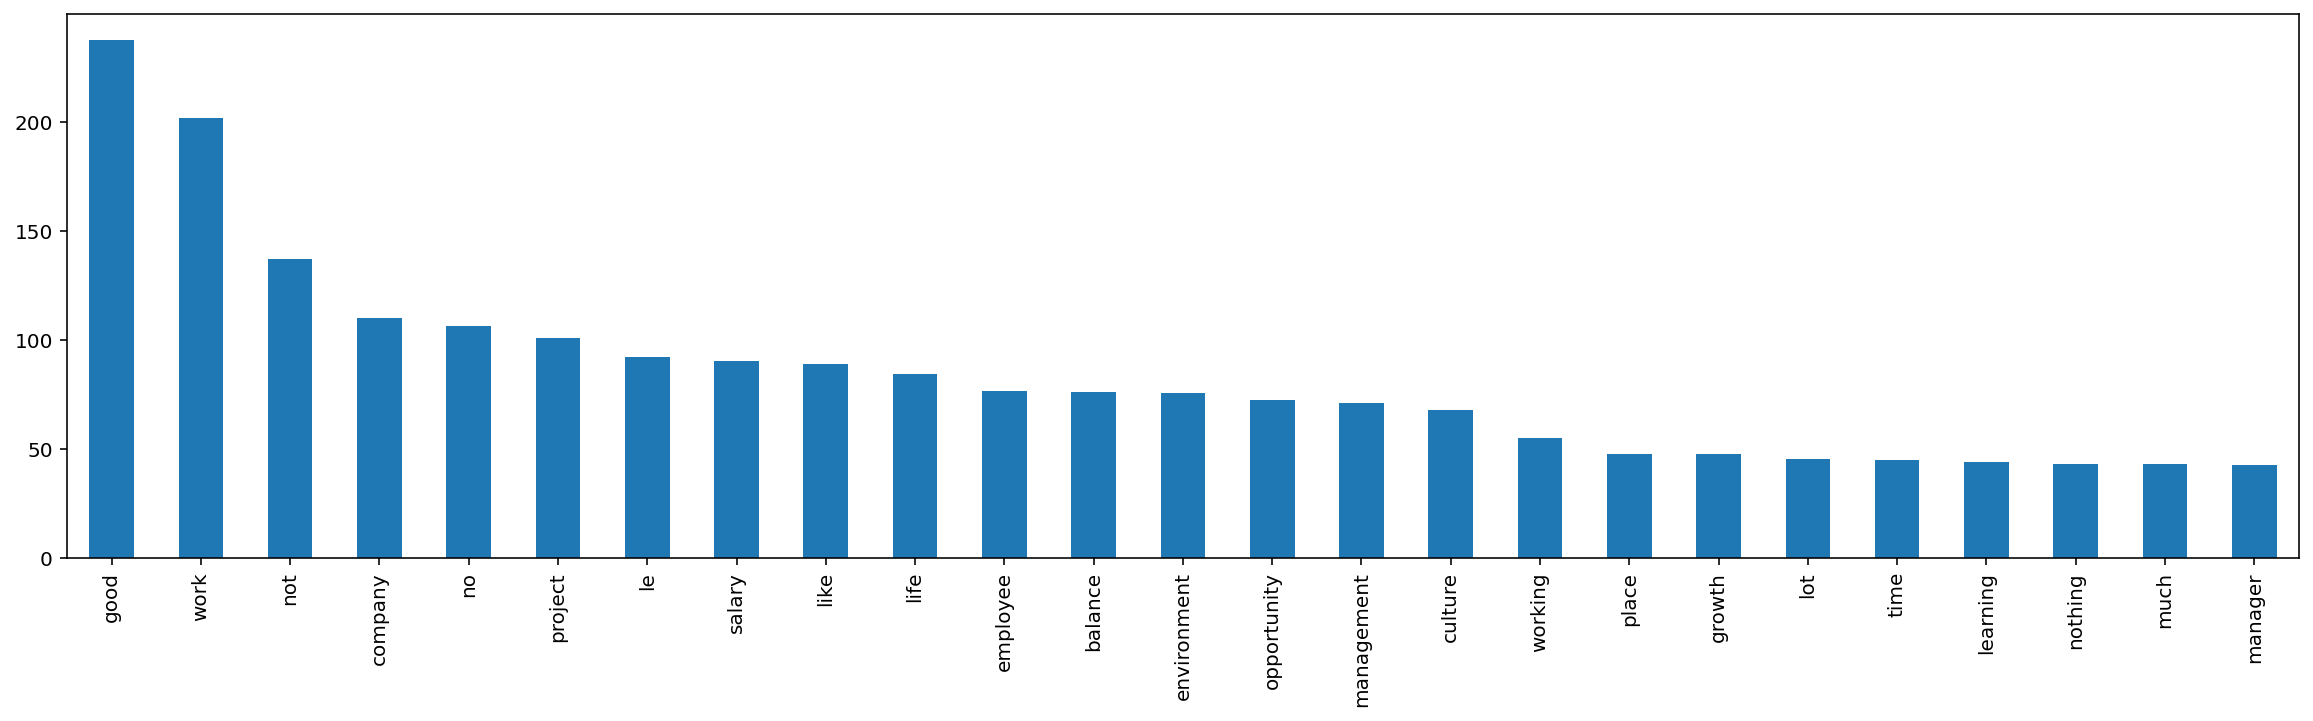

In [36]:
# create a Unigram TFIDF vectorizer object
Unigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1),max_features = 100,stop_words = stopwords)
X_tfidfgram = Unigram_tfidf_vectorizer.fit_transform(train_df['review_clean'])
# Creating a DTM
TFidfunigram = pd.DataFrame(X_tfidfgram.toarray(), columns=Unigram_tfidf_vectorizer.get_feature_names())
# Plot bar graph for top 25 frequenctly used unigrams
TFidfunigram.sum().sort_values(ascending=False).head(25).plot.bar(figsize=(20,5)) 

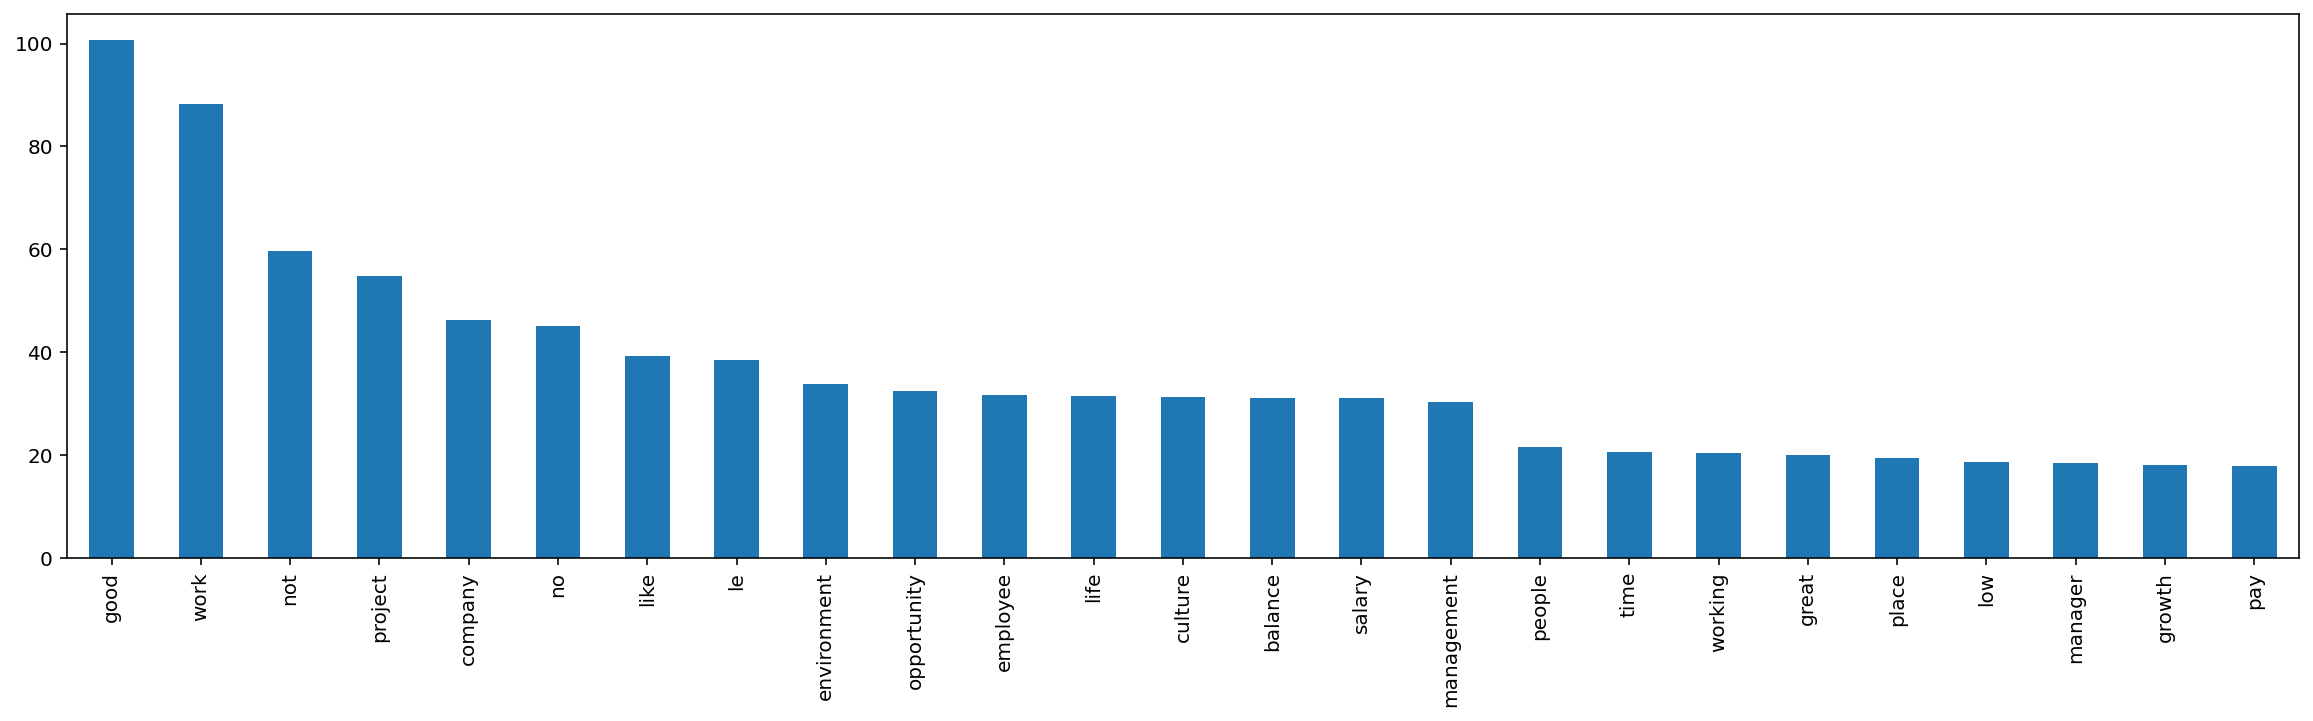

In [37]:
# create a Unigram TFIDF vectorizer object
Unigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1),max_features = 100,stop_words = stopwords)
X_tfidfgram = Unigram_tfidf_vectorizer.fit_transform(test_df['review_clean'])
# Creating a DTM
TFidfunigram = pd.DataFrame(X_tfidfgram.toarray(), columns=Unigram_tfidf_vectorizer.get_feature_names())
# Plot bar graph for top 25 frequenctly used unigrams
TFidfunigram.sum().sort_values(ascending=False).head(25).plot.bar(figsize=(20,5)) 

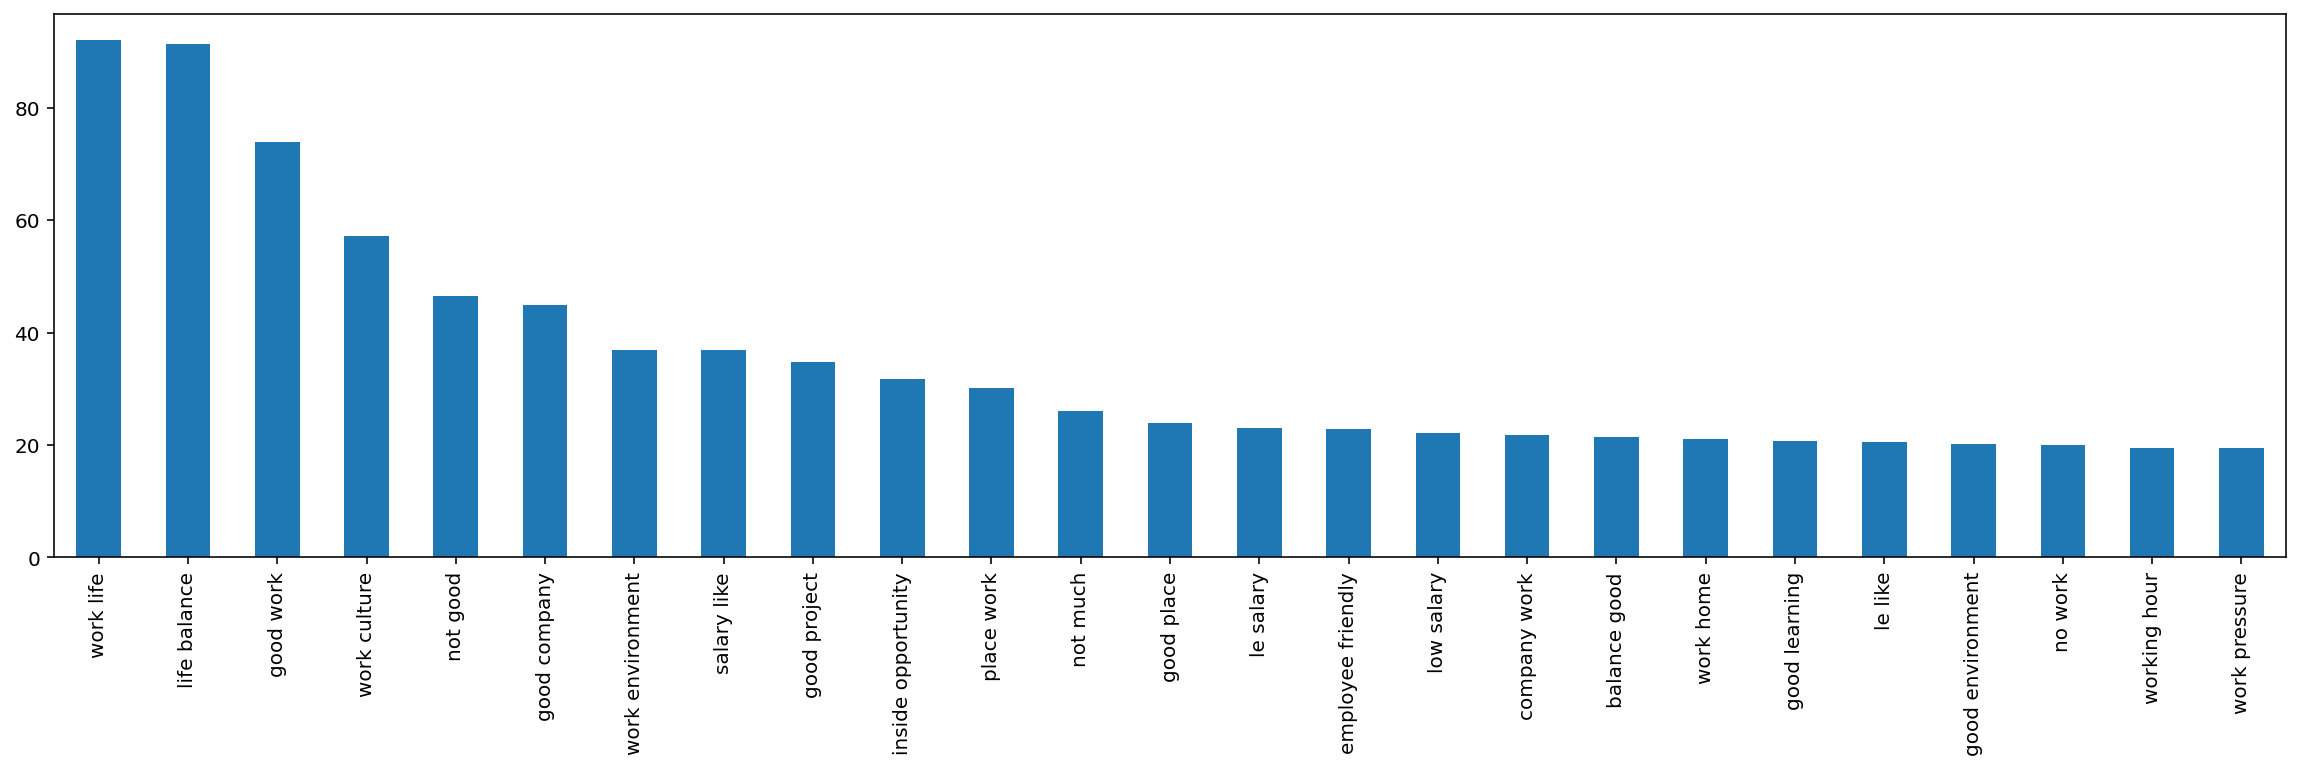

In [38]:
#Plot the bar graph for top 25 frequenctly used bigrams
# create a Bigram TFIDF vectorizer object
Bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2),max_features = 100, stop_words = stopwords)
X_tfidfgram = Bigram_tfidf_vectorizer.fit_transform(train_df['review_clean'])
# Creating a DTM
TFidfBigram = pd.DataFrame(X_tfidfgram.toarray(), columns=Bigram_tfidf_vectorizer.get_feature_names())
# Plot bar graph for top 25 frequenctly used Bigrams
TFidfBigram.sum().sort_values(ascending=False).head(25).plot.bar(figsize=(20,5)) 

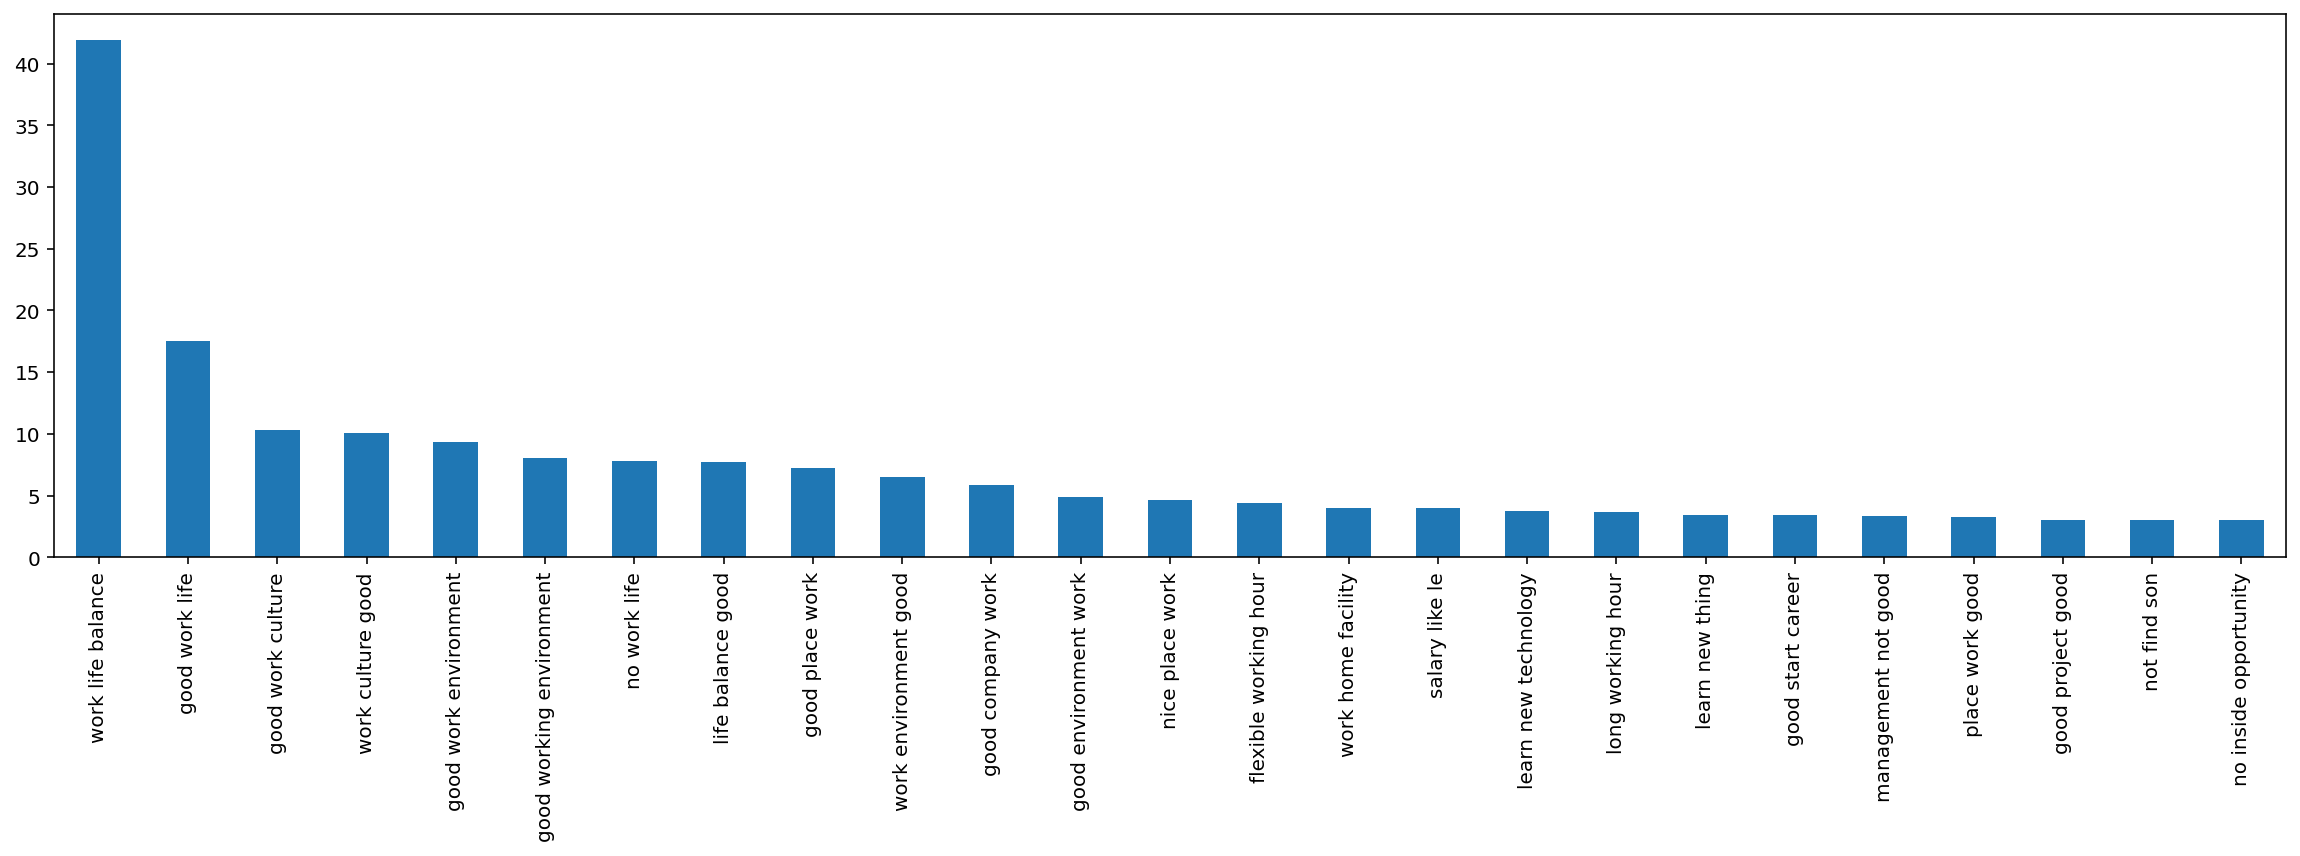

In [39]:
#Plot the bar graph for top 25 frequenctly used Trigrams
# create a Trigram TFIDF vectorizer object
Trigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(3,3),max_features = 100,stop_words = stopwords)
X_tfidfgram = Trigram_tfidf_vectorizer.fit_transform(test_df['review_clean'])
# Creating a DTM
TFidfTrigram = pd.DataFrame(X_tfidfgram.toarray(), columns=Trigram_tfidf_vectorizer.get_feature_names())
# Plot bar graph for top 25 frequenctly used Trigrams
TFidfTrigram.sum().sort_values(ascending=False).head(25).plot.bar(figsize=(20,5)) 

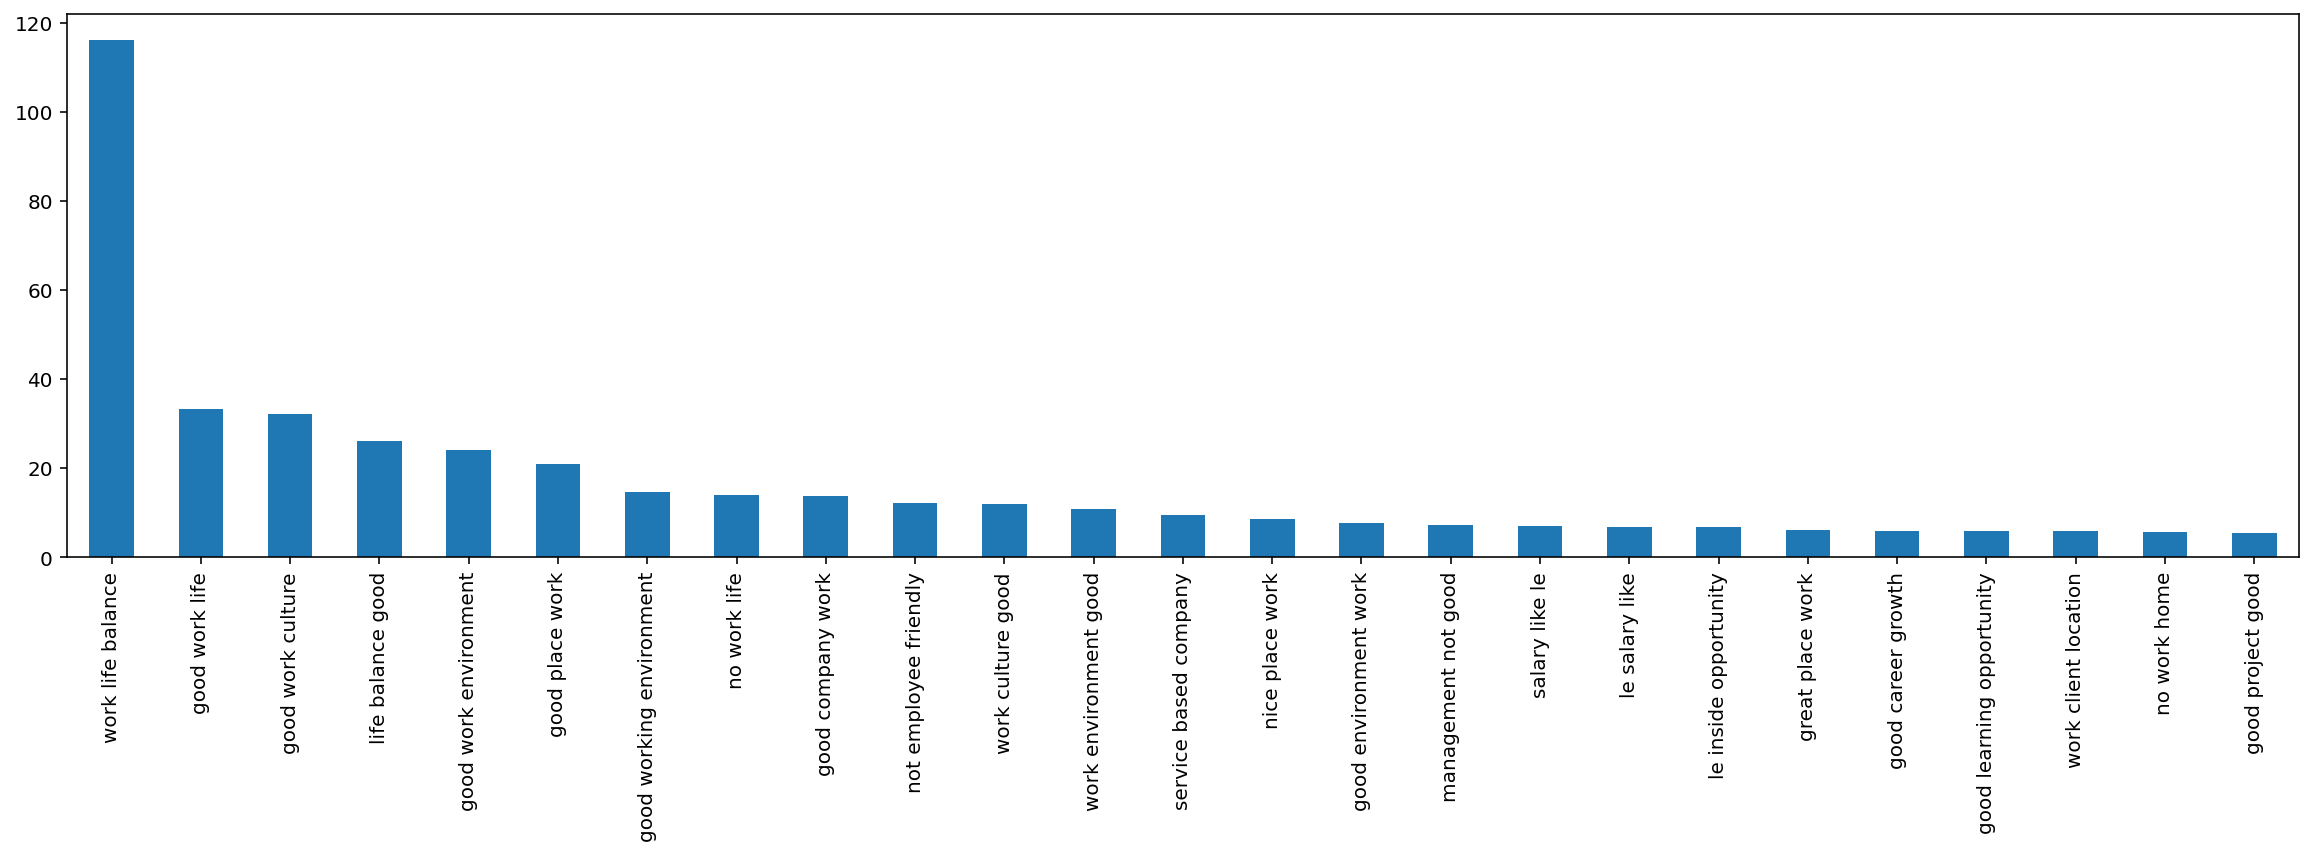

In [40]:
#Plot the bar graph for top 25 frequenctly used Trigrams
# create a Trigram TFIDF vectorizer object
Trigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(3,3),max_features = 100,stop_words = stopwords)
X_tfidfgram = Trigram_tfidf_vectorizer.fit_transform(train_df['review_clean'])
# Creating a DTM
TFidfTrigram = pd.DataFrame(X_tfidfgram.toarray(), columns=Trigram_tfidf_vectorizer.get_feature_names())
# Plot bar graph for top 25 frequenctly used Trigrams
TFidfTrigram.sum().sort_values(ascending=False).head(25).plot.bar(figsize=(20,5)) 

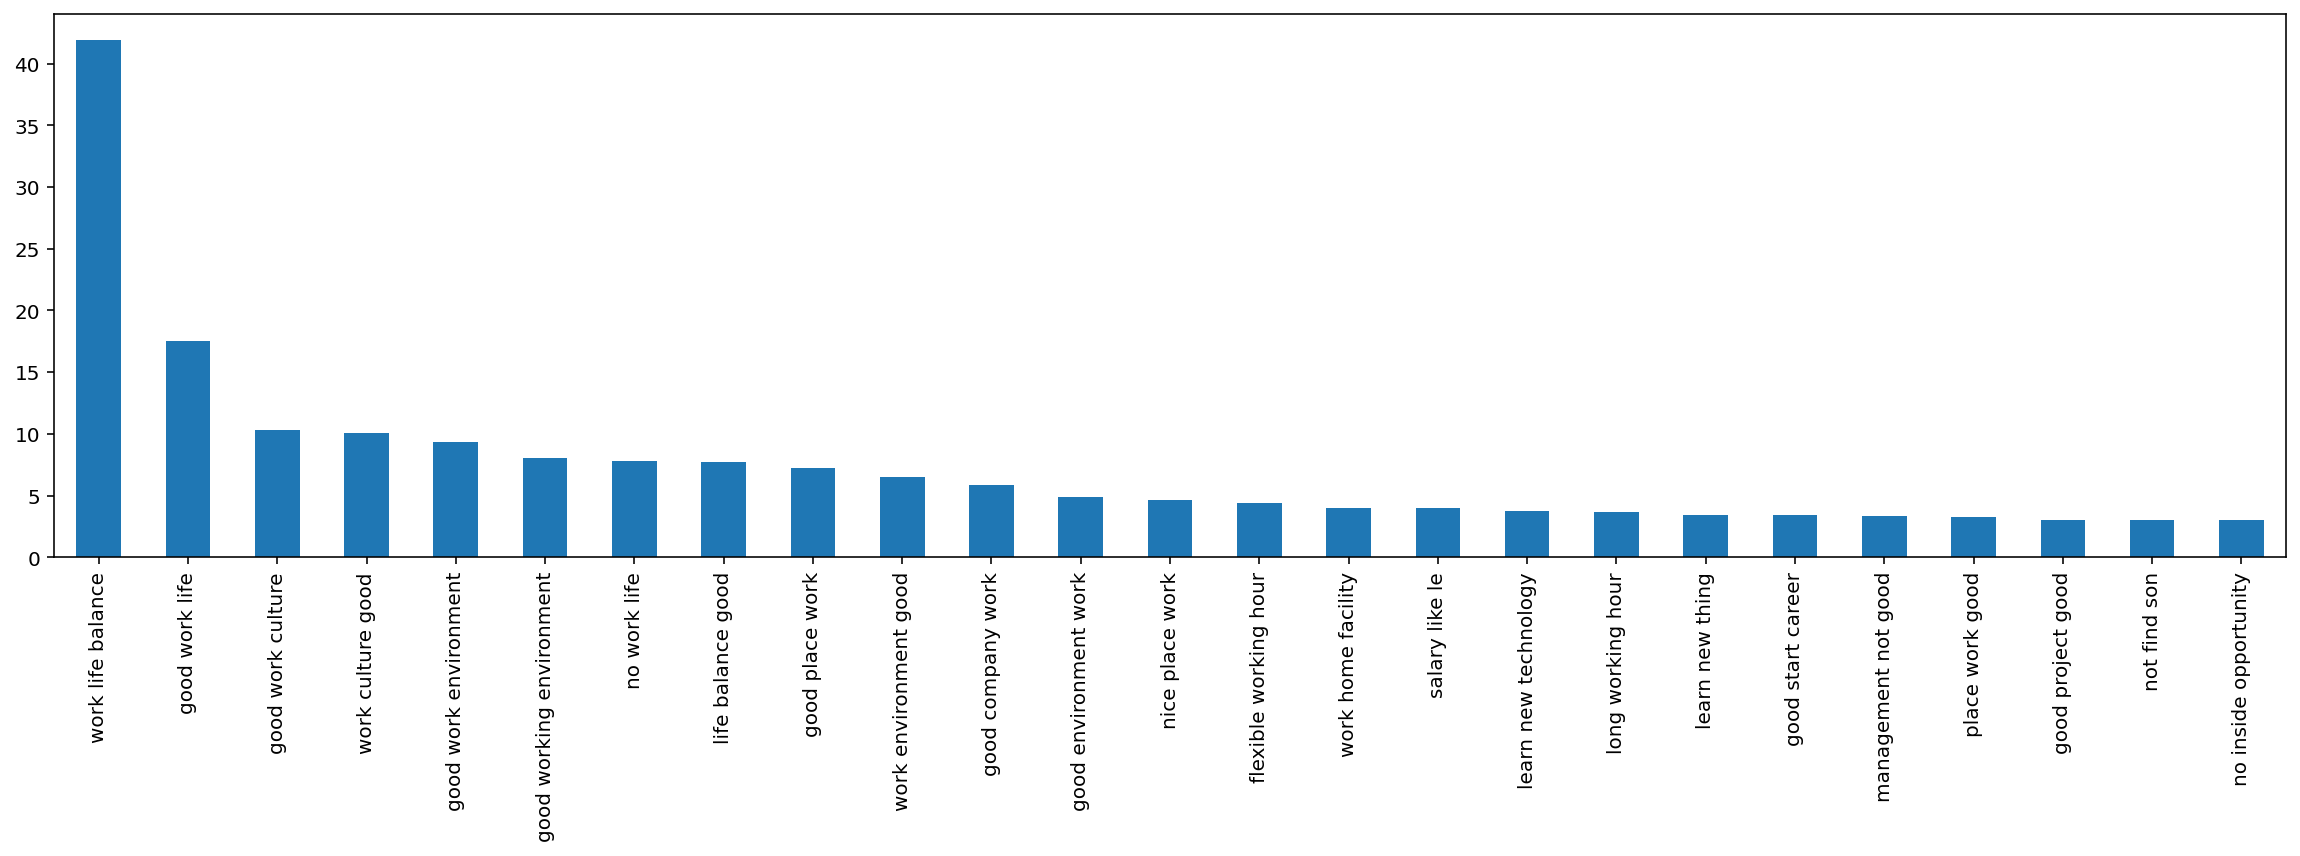

In [41]:
#Plot the bar graph for top 25 frequenctly used Trigrams
# create a Trigram TFIDF vectorizer object
Trigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(3,3),max_features = 100,stop_words = stopwords)
X_tfidfgram = Trigram_tfidf_vectorizer.fit_transform(test_df['review_clean'])
# Creating a DTM
TFidfTrigram = pd.DataFrame(X_tfidfgram.toarray(), columns=Trigram_tfidf_vectorizer.get_feature_names())
# Plot bar graph for top 25 frequenctly used Trigrams
TFidfTrigram.sum().sort_values(ascending=False).head(25).plot.bar(figsize=(20,5)) 

# Models

In [42]:
#Logistic Regression with TFVectorizer
#Importing Libraries

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.feature_extraction.text import CountVectorizer

In [43]:
reviews_train = train_df["review_clean"]
reviews_test = test_df["review_clean"]
y = train_df["sentiment"]

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vectorizer.fit(reviews_train)
X_train = tfidf_vectorizer.transform(reviews_train)
X_test =  tfidf_vectorizer.transform(reviews_test)

# define model
model = LogisticRegression()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)
# define search
search = RandomizedSearchCV(model, space, n_iter=1000, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_train, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9084251381617219
Best Hyperparameters: {'C': 42.93807693006186, 'penalty': 'l2', 'solver': 'lbfgs'}


In [44]:
#Predict for test data
y_pred = search.predict(X_test)
df_sub3 = pd.DataFrame(np.hstack((test_df[['ID']],y_pred.reshape(-1,1))),columns=['ID','sentiment'])
df_sub3.to_csv(r'C:\Users\singh_j\Desktop\Hackathon 2\Submissions\sample_submission_LR_TFIDF.csv',index=False)

In [45]:
# Logistic Regression with Count Vectorizer
ngram_vectorizer = CountVectorizer(ngram_range=(1, 2))
ngram_vectorizer.fit(reviews_train)
X_train = ngram_vectorizer.transform(reviews_train)
X_test = ngram_vectorizer.transform(reviews_test)

In [46]:
# define model
model = LogisticRegression()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)
# define search
search = RandomizedSearchCV(model, space, n_iter=1000, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_train, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Best Score: 0.905638270796975
Best Hyperparameters: {'C': 3.225969977312601, 'penalty': 'l2', 'solver': 'liblinear'}


In [47]:
#Predict for test data
model_LR = LogisticRegression(C = 0.5, penalty = 'l2', solver = 'lbfgs')
search = model_LR.fit(X_train, y)
y_pred1 = search.predict(X_test)
df_sub1 = pd.DataFrame(np.hstack((test_df[['ID']],y_pred1.reshape(-1,1))),columns=['ID','sentiment'])
df_sub1.to_csv(r'C:\Users\singh_j\Desktop\Hackathon 2\Submissions\sample_submission_LR_Count_vect.csv',index=False)



In [48]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC


In [49]:
ngram_vectorizer = CountVectorizer(ngram_range=(1, 2))
ngram_vectorizer.fit(reviews_train)
X_train = ngram_vectorizer.transform(reviews_train)
X_test = ngram_vectorizer.transform(reviews_test)

# define model
svc = SVC()


# Define the search space
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear','rbf']}

# Set up score
scoring = ['accuracy']

# Set up the k-fold cross-validation

kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=1)
# Define random search

random_search = RandomizedSearchCV(estimator=svc, 
                           param_distributions=param_grid, 
                           n_iter=100,
                           scoring=scoring, 
                           refit='accuracy', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
result = random_search.fit(X_train, y)


In [50]:
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9021469604421174
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 0.01, 'C': 10}


In [51]:
#Predict for test data
y_pred = random_search.predict(X_test)
df_sub2 = pd.DataFrame(np.hstack((test_df[['ID']],y_pred.reshape(-1,1))),columns=['ID','sentiment'])
df_sub2.to_csv('sample_submission_SVC_Count_vect.csv',index=False)

#SVC with TFIDF Vectorizer

In [52]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vectorizer.fit(reviews_train)
X_train = tfidf_vectorizer.transform(reviews_train)
X_test =  tfidf_vectorizer.transform(reviews_test)

# define model
svc = SVC()

# Define the search space
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear','rbf']}
# Set up score
scoring = ['accuracy']

# Set up the k-fold cross-validation

kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=1)

# Define random search

random_search = RandomizedSearchCV(estimator=svc, 
                           param_distributions=param_grid, 
                           n_iter=100,
                           scoring=scoring, 
                           refit='accuracy', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
result = random_search.fit(X_train, y)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Best Score: 0.9094731675392669
Best Hyperparameters: {'kernel': 'linear', 'gamma': 1, 'C': 1}


In [53]:
#Predict for test data
y_pred_svc_tf = random_search.predict(X_test)
df_sub2 = pd.DataFrame(np.hstack((test_df[['ID']],y_pred_svc_tf.reshape(-1,1))),columns=['ID','sentiment'])
df_sub2.to_csv('sample_submission_svc_TF_IDF.csv',index=False)

# Random Forest with TfIdf

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vectorizer.fit(reviews_train)
X_train = tfidf_vectorizer.transform(reviews_train)
X_test =  tfidf_vectorizer.transform(reviews_test)

# define model
rf = RandomForestClassifier()

# Define the search space
param_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [130, 180, 230]}
# Set up score
scoring = ['accuracy']

# Set up the k-fold cross-validation

kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=1)

# Define random search

random_search = RandomizedSearchCV(estimator=rf, 
                           param_distributions=param_grid, 
                           n_iter=100,
                           scoring=scoring, 
                           refit='accuracy', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
result = random_search.fit(X_train, y)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


In [ ]:
#Predict for test data
y_pred_svc_tf = random_search.predict(X_test)
df_sub2 = pd.DataFrame(np.hstack((test_df[['ID']],y_pred_svc_tf.reshape(-1,1))),columns=['ID','sentiment'])
df_sub2.to_csv('sample_submission_RF_TF_IDF.csv',index=False)